In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [818]:
#normalize data
def normalize_features(df):
    return df.divide(df.max(axis=0),axis=1)

def feature_rebase(train,test,col_name,new_col,new_values):
    key_list = list(new_values.keys())
    if 'default' in new_values.keys():
        train[new_col] = new_values['default']
        test[new_col] = new_values['default']
        key_list.remove('default')
        
    for k in key_list:
        train[new_col].loc[train[train[col_name]==k].index] = new_values[k]
        test[new_col].loc[test[test[col_name]==k].index] = new_values[k]
        
    return train, test

def fill_by_mode(df, tgt_col, rel_cols=None, null_val = np.nan):
    if rel_cols == None:
        #select rel_cols based on highest correlation, arbitrary cutoff at 7
        hunt_corr = abs(df.corr()[tgt_col])
        end = np.min((len(hunt_corr[1:]),7))
        rel_cols = list(hunt_corr.sort_values(ascending=False)[1:end].index)
    
    print('by mode: ',tgt_col, rel_cols)
    summ_dict = {}
    summ_dict['rel_cols'] = rel_cols
    k_used = list()
    hunt_dict = {}
    gs = df.copy()
    
    tgt_ind = list(df[df[tgt_col].isna()].index)
    for i in tgt_ind:
        for col in rel_cols:
            hunt_dict[col] = df[col].loc[i]
        
        for k in hunt_dict:
            if len(gs.loc[gs[gs[k] == hunt_dict[k]].index]) > 0:
                gs = gs.loc[gs[gs[k] == hunt_dict[k]].index]
                k_used.append(k)
        
        if len(gs[tgt_col].mode()) == 0:
                df[tgt_col].loc[i] = null_val
        else: 
            df[tgt_col].loc[i] = gs[tgt_col].mode()
        summ_dict[i] = k_used
        hunt_dict = {}
        k_used = list()
    
    return df, pd.DataFrame.from_dict(summ_dict, orient='index')


def fill_by_mean(df, tgt_col, rel_cols=None, null_val = np.nan):
    df = df
    tgt_col = tgt_col
    if rel_cols == None:
        #select rel_cols based on highest correlation, arbitrary cutoff at 7
        hunt_corr = abs(df.corr()[tgt_col])
        end = np.min((len(hunt_corr[1:]),7))
        rel_cols = list(hunt_corr.sort_values(ascending=False)[1:end].index)
    
    print('by mean: ',tgt_col, rel_cols)
    summ_dict = {}
    summ_dict['rel_cols'] = rel_cols
    k_used = list()
    hunt_dict = {}
    gs = df
    tgt_ind = list(df[df[tgt_col].isna()].index)
    for i in tgt_ind:

        for col in rel_cols:
            hunt_dict[col] = df[col].loc[i]
        
        for k in hunt_dict:
            if len(gs.loc[gs[gs[k] == hunt_dict[k]].index]) > 0:
                gs = gs.loc[gs[gs[k] == hunt_dict[k]].index]
                k_used.append(k)
        
        if len(gs[tgt_col].mode()) == 0:
                df[tgt_col].loc[i] = null_val
        else: 
            df[tgt_col].loc[i] = gs[tgt_col].mean()
        
        summ_dict[i] = k_used
        hunt_dict = {}
        k_used = list()
        gs = df
    
    return df, pd.DataFrame.from_dict(summ_dict, orient='index')

# load data, set index, review where missing values are

In [819]:
file_loc = '/Users/gregscanlon/Documents/Kaggle/titanic/'
init_train = pd.read_csv(file_loc+'train.csv')
init_test = pd.read_csv(file_loc+'test.csv')

train = init_train
ind = 'PassengerId'
train.set_index(ind,inplace=True)
test = init_test
test.set_index(ind,inplace=True)

#check data
check_dict = {'Sex':2,'Embarked': 3,'Pclass':3}

for k in check_dict:
    
    print('train unique match: ', k, len(train[k].unique())==check_dict[k])
    print('test unique match: ', k, len(test[k].unique())==check_dict[k])

train_na = list()
for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        train_na.append(col)
        
test_na = list()
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))
        test_na.append(col)

train unique match:  Sex True
test unique match:  Sex True
train unique match:  Embarked False
test unique match:  Embarked True
train unique match:  Pclass True
test unique match:  Pclass True
na in train  Age % of total:  0.19865319865319866
na in train  Cabin % of total:  0.7710437710437711
na in train  Embarked % of total:  0.002244668911335578
na in test  Age % of total:  0.20574162679425836
na in test  Fare % of total:  0.0023923444976076554
na in test  Cabin % of total:  0.7822966507177034


# Feature Generation, Part A

In [822]:
#feature generation
#first generate some features so we can then fill values
columns = ['Pclass','SibSp','Parch','Age']

#male-female to 0 1
#male: 0
#female: 1
col_name = 'Sex'
new_col = 'm_f'
new_values = {'default':0,'female':1}

train, test = feature_rebase(train,test,col_name,new_col,new_values)

columns.append(new_col)

#embarked
#nan:0
#S:1
#C:2
#Q:3
col_name = 'Embarked'
new_col = 'embark_num'
new_values = {'default':0,'S':1,'C':2,'Q':3}

train, test = feature_rebase(train,test,col_name,new_col,new_values)

columns.append(new_col)

#length of name
col_name = 'Name'
new_col = 'name_len'
train[new_col] = train[col_name].str.len()/train[col_name].str.len().max()
test[new_col] = test[col_name].str.len()/test[col_name].str.len().max()

columns.append(new_col)


'''#normalize fare
col_name = 'Fare'
new_col = 'fare_norm'
train[new_col] = train[col_name]/train[col_name].max()
test[new_col] = test[col_name]/test[col_name].max()

columns.append(new_col)

#normalize age
col_name = 'Age'
new_col = 'age_norm'
train[new_col] = train[col_name]/train[col_name].max()
test[new_col] = test[col_name]/test[col_name].max()

columns.append(new_col)'''

col_name = 'Cabin'
new_col = 'cabin_bin'
train[new_col] = train[col_name].str.len()>0
test[new_col] = test[col_name].str.len()>0

col_name = 'Ticket'
new_col = 'ticket_alpha'
train[new_col] = train[col_name].str.contains('[^\W\d_]')*1
test[new_col] = test[col_name].str.contains('[^\W\d_]')*1

#line workers with Fare = $0 get Cabin = 'L' and Fare = $0.01
train['Cabin'].loc[train[train['Ticket']=='LINE'].index] = 'L'
train['Fare'].loc[train[train['Ticket']=='LINE'].index] = 0.01

train['cabin_alpha'] = train['Cabin'].str.extract(r'(\w)')
train['cabin_num'] = train['Cabin'].str.extract(r'(\d+)').astype(float)

test['cabin_alpha'] = test['Cabin'].str.extract(r'(\w)')
test['cabin_num'] = test['Cabin'].str.extract(r'(\d+)').astype(float)

#if you were a lower class parent/child, assign to 'ZP'
train['cabin_alpha'].loc[train[(train['cabin_alpha'].isna())&(train['Pclass']==3)&(train['Parch']>0)].index] = 'ZP'
test['cabin_alpha'].loc[test[(test['cabin_alpha'].isna())&(test['Pclass']==3)&(test['Parch']>0)].index] = 'ZP'

# Fill missing and Fare = 0 values

In [772]:
#set fares that are $0 to nan so we can estimate them for train and test
train['Fare'][train['Fare']==0] = np.nan
test['Fare'][test['Fare']==0] = np.nan

#fill in missing values using most correlated features and mean,mode
train_summary = {}
train_na = ['Fare','Age','embark_num']
for col in train_na:
    if np.issubdtype(train[col].dtype , np.number):
        train, train_summary[col] = fill_by_mean(train,col,null_val = train[col].median())
        
    else:        
        train, train_summary[col] = fill_by_mode(train,col)

#assign everyone to a cabin_alpha = class
train, train_summary['cabin_alpha'] = fill_by_mode(train,'cabin_alpha',['Fare','Pclass','Parch','m_f','Age','embark_num'],'U')

test_na = ['Fare','Age','embark_num']
test_summary = {}
for col in test_na:
    if np.issubdtype(train[col].dtype , np.number):
        test, test_summary[col] = fill_by_mean(test,col, null_val = test[col].median())
        
    else:
        test, test_summary[col] = fill_by_mode(test,col)
        
#assign everyone to a cabin_alpha = class
test, test_summary['cabin_alpha'] = fill_by_mode(test,'cabin_alpha',['Fare','Pclass','Parch','m_f','Age'],'U')


for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        train_na.append(col)
        
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))
        test_na.append(col)

/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


by mean:  Fare ['Pclass', 'cabin_bin', 'Survived', 'Parch', 'm_f', 'ticket_alpha']
by mean:  Age ['Pclass', 'SibSp', 'cabin_bin', 'Parch', 'Fare', 'm_f']
by mean:  embark_num ['m_f', 'name_len', 'Survived', 'ticket_alpha', 'Parch', 'cabin_num']
by mode:  cabin_alpha ['Fare', 'Pclass', 'Parch', 'm_f', 'Age', 'embark_num']
by mean:  Fare ['Pclass', 'cabin_bin', 'Age', 'cabin_num', 'Parch', 'name_len']
by mean:  Age ['Pclass', 'cabin_bin', 'Fare', 'name_len', 'embark_num', 'cabin_num']
by mean:  embark_num ['cabin_num', 'ticket_alpha', 'm_f', 'Parch', 'SibSp', 'name_len']
by mode:  cabin_alpha ['Fare', 'Pclass', 'Parch', 'm_f', 'Age']
na in train  Cabin % of total:  0.7665544332210998
na in train  Embarked % of total:  0.002244668911335578
na in train  cabin_num % of total:  0.7755331088664422
na in test  Cabin % of total:  0.7822966507177034
na in test  cabin_num % of total:  0.7870813397129187


In [777]:
#ONEHOT encode the cabin_alpha column from letters to numbers
# we can then use this calculate correlation and assigned everyone to a cabin_alpha = class


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

cat_cols = 'cabin_alpha'
x = list(train[cat_cols].unique().reshape(-1,1))

#cat_cols = ['Sex','Embarked','Ticket','Cabin']
#x = train[cat_cols].values
enc.fit(x)
onehot = enc.transform(train[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_train_df = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_train_df.set_index(train.index,inplace=True)

onehot = enc.transform(test[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_test_df = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_test_df.set_index(test.index,inplace=True)

In [795]:
#features from walk-through
#title
## get the title from the name
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]
## Let's fix that
train.title = train.title.apply(lambda x: x.strip())

In [796]:
train.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [804]:
#features from walk-through
#title
## get the title from the name
train["title"] = [i.split('.')[0] for i in train.Name]
train["title"] = [i.split(',')[1] for i in train.title]
## Let's fix that
train.title = train.title.apply(lambda x: x.strip())

## Let's replace some of the rare values with the keyword 'rare' and other word choice of our own. 
## train Data
title_dict = {}
title_list = list(train.title.unique())
title_dict['Mr'] = 'Mr'
title_list.remove('Mr')
title_dict['Ms'] = 'Miss'
title_list.remove('Ms')
title_dict['Mlle'] = 'Miss'
title_list.remove('Mlle')
title_dict['Mrs'] = 'Mrs'
title_list.remove('Mrs')

#set rest to rare
for t in title_list:
    title_dict[t] = 'rare'

    
for i in train.index:
    train['title'].loc[i] = title_dict[train['title'].loc[i]]
    

#features from walk-through
#title
## get the title from the name
test["title"] = [i.split('.')[0] for i in test.Name]
test["title"] = [i.split(',')[1] for i in test.title]
## Let's fix that
test.title = test.title.apply(lambda x: x.strip())

title_list = list(test.title.unique())

#set rest to rare
for t in title_list:
    if t not in title_dict.keys():
        title_dict[t] = 'rare'
    
## Let's replace some of the rare values with the keyword 'rare' and other word choice of our own. 
## train Data
for i in test.index:
    test['title'].loc[i] = title_dict[test['title'].loc[i]]


#FAMILY SIZE
## Family_size seems like a good feature to create
train['family_size'] = train.SibSp + train.Parch+1
test['family_size'] = test.SibSp + test.Parch+1

def family_group(size):
    """
    This funciton groups(loner, small, large) family based on family size
    """
    
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

train['is_alone'] = [1 if i<2 else 0 for i in train.family_size]
test['is_alone'] = [1 if i<2 else 0 for i in test.family_size]

## Calculating fare based on family size. 
train['calculated_fare'] = train.Fare/train.family_size
test['calculated_fare'] = test.Fare/test.family_size

def fare_group(fare):
    """
    This function creates a fare group based on the fare provided
    """
    
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

##AGE
##Random forest regressor in this section to predict the missing age values. Let's do it


In [783]:
cols_learn = ['Pclass',
 'SibSp',
 'Parch',
 'Age',
 'm_f',
 'embark_num',
 'name_len',
 'Fare',
 'cabin_bin','ticket_alpha']

In [787]:
#dont use OneHot on cabin and Ticket, just use 0-1 if they have one

X = train[cols_learn]
X = X.merge(onehot_train_df,left_index=True,right_index=True)

y = train['Survived']

gs_test = test[cols_learn]
gs_test = gs_test.merge(onehot_test_df,left_index=True,right_index=True)

X.to_excel(file_loc+'X_processed.xlsx')
y.to_excel(file_loc+'y_processed.xlsx',header=True)
gs_test.to_excel(file_loc+'gs_test_processed.xlsx')

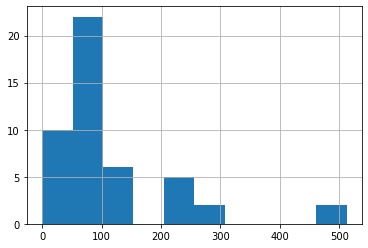

In [487]:
train['Fare'][train['cabin_alpha'] == 'B'].hist()

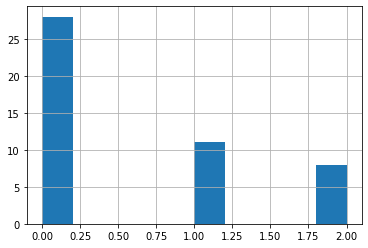

In [489]:
train['Parch'][train['cabin_alpha'] == 'B'].hist()

In [ ]:
rel_cols = ['Pclass','m_f','Parch','name_len','cabin_bin','ticket_alpha']

In [416]:
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch']

#fill missing age with average of sex, Sibsp, Parch, Pclass
col = 'Age'
for i in train.index:
    if np.isnan(train[col].loc[i]):
        #print('Age ',i)
        train[col].loc[i] = train[(train[rel_cols[0]]==train[rel_cols[0]].loc[i])&(train[rel_cols[1]]==train[rel_cols[1]].loc[i])&(train[rel_cols[2]]==train[rel_cols[2]].loc[i])&(train[rel_cols[3]]==train[rel_cols[3]].loc[i])]['Age'].mean()
        if np.isnan(train[col].loc[i]):
            train[col].loc[i] = train[col].mean()



#fill missing age with average of sex, Sibsp, Parch, Pclass
col = 'Age'
for i in test.index:
    if np.isnan(test[col].loc[i]):
        #print('Age ',i)
        test[col].loc[i] = test[(test[rel_cols[0]]==test[rel_cols[0]].loc[i])&(test[rel_cols[1]]==test[rel_cols[1]].loc[i])&(test[rel_cols[2]]==test[rel_cols[2]].loc[i])&(test[rel_cols[3]]==test[rel_cols[3]].loc[i])]['Age'].mean()
        if np.isnan(test[col].loc[i]):
            test[col].loc[i] = test[col].mean()
            
#fill missing embarked with mode of sex, Sibsp, Parch, Pclass
#use code above, filling for now with correct answer
tgt_col = 'Embarked'
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Fare']
train = fill_by_mode(train,tgt_col,rel_cols)

        
tgt_col = 'Fare'
rel_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked']    
test['Fare'].fillna(0,inplace=True)

#train['Cabin'].fillna('None',inplace=True)
#test['Cabin'].fillna('None',inplace=True)

In [344]:
for col in train:
    if train[col].isna().any():
        print('na in train ',col, '% of total: ',len(train[train[col].isna()])/len(train[col]))
        
for col in test:
    if test[col].isna().any():
        print('na in test ',col, '% of total: ',len(test[test[col].isna()])/len(test[col]))

na in train  Cabin % of total:  0.7710437710437711
na in test  Cabin % of total:  0.7822966507177034


In [277]:
#ONEHOT encode the Ticket column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

cat_cols = 'Ticket'
x = list(train[cat_cols].unique().reshape(-1,1))

#cat_cols = ['Sex','Embarked','Ticket','Cabin']
#x = train[cat_cols].values
enc.fit(x)
onehot = enc.transform(train[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_train_tkt = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_train_tkt.set_index(train.index,inplace=True)

onehot = enc.transform(test[cat_cols].values.reshape(-1,1)).toarray()

#put onehot into df to later merge with data
onehot_test_tkt = pd.DataFrame(data=onehot,columns=enc.categories_[0])
onehot_test_tkt.set_index(test.index,inplace=True)

In [278]:
columns

['Pclass', 'SibSp', 'Parch', 'm_f', 'embark_num', 'name_len']

In [281]:
X = train[columns]
X = X.merge(onehot_train_df,left_index=True,right_index=True)
X = X.merge(onehot_train_tkt,left_index=True,right_index=True)

y = train['Survived']

gs_test = test[columns]

gs_test = gs_test.merge(onehot_test_df,left_index=True,right_index=True)
gs_test = gs_test.merge(onehot_test_tkt,left_index=True,right_index=True)

In [285]:
X.shape[1] == gs_test.shape[1]

True

In [374]:
columns

['Pclass', 'SibSp', 'Parch', 'Age', 'm_f', 'embark_num', 'name_len']

In [375]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'm_f', 'embark_num', 'name_len',
       'cabin_bin', 'ticket_slash', 'ticket_dot', 'ticket_space',
       'ticket_alpha'],
      dtype='object')

In [377]:
columns.append('Fare')
columns.append('cabin_bin')
columns.append('ticket_slash')
columns.append('ticket_dot')
columns.append('ticket_space')
columns.append('ticket_alpha')
columns

['Pclass',
 'SibSp',
 'Parch',
 'Age',
 'm_f',
 'embark_num',
 'name_len',
 'Fare',
 'Fare',
 'cabin_bin',
 'ticket_slash',
 'ticket_dot',
 'ticket_space',
 'ticket_alpha']

In [382]:
columns

['Pclass',
 'SibSp',
 'Parch',
 'Age',
 'm_f',
 'embark_num',
 'name_len',
 'Fare',
 'cabin_bin',
 'ticket_slash',
 'ticket_dot',
 'ticket_space',
 'ticket_alpha']

In [318]:
X

Pclass  SibSp  Parch        Age  m_f  embark_num  name_len
PassengerId                                                            
1                 3      1      0  22.000000    0           1  0.280488
2                 1      1      0  38.000000    1           2  0.621951
3                 3      0      0  26.000000    1           1  0.268293
4                 1      1      0  35.000000    1           1  0.536585
5                 3      0      0  35.000000    0           1  0.292683
...             ...    ...    ...        ...  ...         ...       ...
887               2      0      0  27.000000    0           1  0.256098
888               1      0      0  19.000000    1           1  0.341463
889               3      1      2  29.684771    1           1  0.487805
890               1      0      0  26.000000    0           2  0.256098
891               3      0      0  32.000000    0           3  0.231707

[891 rows x 7 columns]

In [320]:
#write X, y and test to csv for use later



In [96]:
X = train[columns]

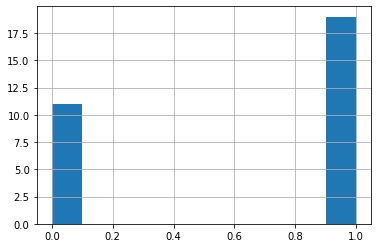

In [120]:
train['Survived'][(train['Age']<10) & (train['Sex']=='female')].hist()

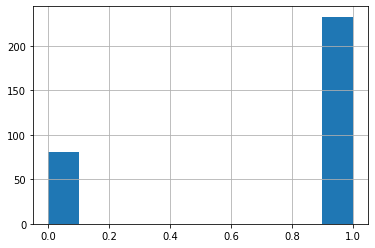

In [122]:
train['Survived'][train['Sex']=='female'].hist()

age_norm


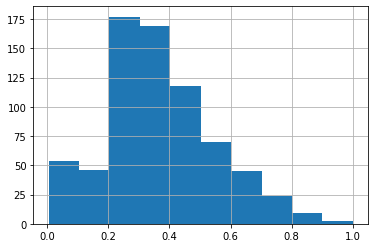

In [104]:
n=8
print(X.columns[n])
X[X.columns[n]].hist()

fare_norm


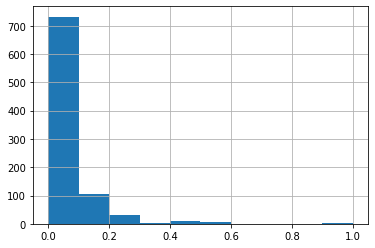

In [103]:
n=7
print(X.columns[n])
X[X.columns[n]].hist()

name_len


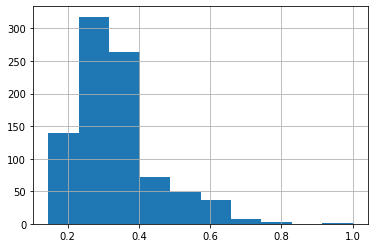

In [102]:
n=6
print(X.columns[n])
X[X.columns[n]].hist()

embark_num


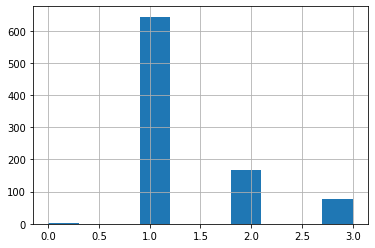

In [101]:
n=5
print(X.columns[n])
X[X.columns[n]].hist()

m_f


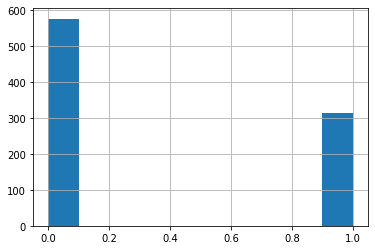

In [100]:
n=4
print(X.columns[n])
X[X.columns[n]].hist()

Parch


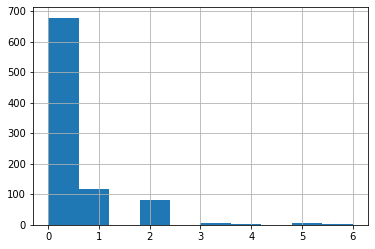

In [93]:
n=3
print(X.columns[n])
X[X.columns[n]].hist()

SibSp


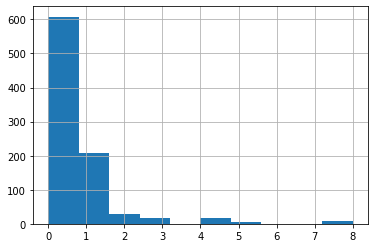

In [94]:
n=2
print(X.columns[n])
X[X.columns[n]].hist()

Pclass


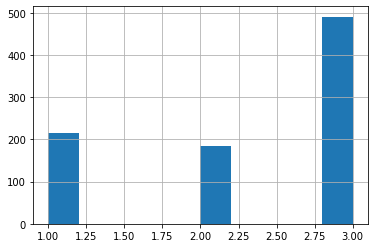

In [95]:
n=1
print(X.columns[n])
X[X.columns[n]].hist()

# Visualizations

In [287]:
init_train

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex  \
PassengerId                                                              
1                                      Braund, Mr. Owen Harris    male   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
3                                       Heikkinen, Miss. Laina  female   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
5                                     Allen, Mr. William Henry    male   
...                                                        ...     ...   
887                                      Montvila, Rev. Juozas    male   
888                               Graham, Miss. Margaret Edith  female   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   
890                                      Behr, Mr. Karl Howell    male   
891                                        Dooley, Mr. Patrick    male   

                   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                             
1            22.000000      1      0         A/5 21171   7.2500  None   
2            38.000000      1      0          PC 17599  71.2833   C85   
3            26.000000      0      0  STON/O2. 3101282   7.9250  None   
4            35.000000      1      0            113803  53.1000  C123   
5            35.000000      0      0            373450   8.0500  None   
...                ...    ...    ...               ...      ...   ...   
887          27.000000      0      0            211536  13.0000  None   
888          19.000000      0      0            112053  30.0000   B42   
889          29.684771      1      2        W./C. 6607  23.4500  None   
890          26.000000      0      0            111369  30.0000  C148   
891          32.000000      0      0            370376   7.7500  None   

            Embarked  m_f  embark_num  name_len  
PassengerId                                      
1                  S    0           1  0.280488  
2                  C    1           2  0.621951  
3                  S    1           1  0.268293  
4                  S    1           1  0.536585  
5                  S    0           1  0.292683  
...              ...  ...         ...       ...  
887                S    0           1  0.256098  
888                S    1           1  0.341463  
889                S    1           1  0.487805  
890                C    0           2  0.256098  
891                Q    0           3  0.231707  

[891 rows x 14 columns]

In [294]:
max_list = []
cat_cols = ['Pclass','Sex','SibSp','Parch','Cabin','Embarked']
for col in cat_cols:
    max_list.append(len(init_train[col].unique()))

In [295]:
max_list

[3, 2, 7, 7, 148, 3]

In [311]:
init_train[init_train[col]==3].groupby('Survived').count()[col]/len(init_train[init_train[col]==3])

Survived
0    0.757637
1    0.242363
Name: Pclass, dtype: float64

In [313]:
import matplotlib.pyplot as plt
#plot % survived for each variable

cat_cols = ['Pclass','Sex','SibSp','Parch','Cabin','Embarked']


#fig, axs = plt.subplots(len(cat_cols), 3, sharex=True, sharey=True)

for col in cat_cols:
    for group in init_train[col].unique():
        tgt = init_train[init_train[col]==group]
        print(col,'/',group)
        print(init_train[init_train[col]==group].groupby('Survived').count()[col]/len(init_train[init_train[col]==group]))

Pclass / 3
Survived
0    0.757637
1    0.242363
Name: Pclass, dtype: float64
Pclass / 1
Survived
0    0.37037
1    0.62963
Name: Pclass, dtype: float64
Pclass / 2
Survived
0    0.527174
1    0.472826
Name: Pclass, dtype: float64
Sex / male
Survived
0    0.811092
1    0.188908
Name: Sex, dtype: float64
Sex / female
Survived
0    0.257962
1    0.742038
Name: Sex, dtype: float64
SibSp / 1
Survived
0    0.464115
1    0.535885
Name: SibSp, dtype: float64
SibSp / 0
Survived
0    0.654605
1    0.345395
Name: SibSp, dtype: float64
SibSp / 3
Survived
0    0.75
1    0.25
Name: SibSp, dtype: float64
SibSp / 4
Survived
0    0.833333
1    0.166667
Name: SibSp, dtype: float64
SibSp / 2
Survived
0    0.535714
1    0.464286
Name: SibSp, dtype: float64
SibSp / 5
Survived
0    1.0
Name: SibSp, dtype: float64
SibSp / 8
Survived
0    1.0
Name: SibSp, dtype: float64
Parch / 0
Survived
0    0.656342
1    0.343658
Name: Parch, dtype: float64
Parch / 1
Survived
0    0.449153
1    0.550847
Name: Parch, dtype: 

Name: Cabin, dtype: float64
Cabin / B3
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / D6
Survived
0    1.0
Name: Cabin, dtype: float64
Cabin / B82 B84
Survived
0    1.0
Name: Cabin, dtype: float64
Cabin / D17
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / A36
Survived
0    1.0
Name: Cabin, dtype: float64
Cabin / B102
Survived
0    1.0
Name: Cabin, dtype: float64
Cabin / B69
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / E49
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / C47
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / D28
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / E17
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / A24
Survived
0    1.0
Name: Cabin, dtype: float64
Cabin / C50
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / B42
Survived
1    1.0
Name: Cabin, dtype: float64
Cabin / C148
Survived
1    1.0
Name: Cabin, dtype: float64
Embarked / S
Survived
0    0.660991
1    0.339009
Name: Embarked, dtype: float64
Embarked / C
Surv

In [155]:
#validation set
X, X_test, y, y_test = train_test_split(X, y, random_state=42)

#scale data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [156]:
#logistic regression
clf = LogisticRegression(random_state=0).fit(X, y)

print('train score: ',clf.score(X, y))

print('test score: ',clf.score(X_test, y_test))

/Users/gregscanlon/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').